# Название проекта: "Прогнозирование оттока клиентов"

**<font color='blue'>Постановка задачи:</font>**  
Перед оператором связи стоит задача научиться прогнозировать отток клиенов.  
На основе имеющихся данных о клиентах и имеющимися у них услугами необходимо предсказать склонен ли клиент к оттоку или нет.  
Если компания поймет, что клиент склонен к оттоку ему будут предложены промокоды и специальные словия обслуживания.

Клиенты в компании пользуюся двумя основными типами услуг: 
- телефонной связью;
- интернетом.

Дополнительно для клиентов имеется возможность подключить следующие услуги:  
- интернет безопасность: антивирус и блокировка небезопасных сайтов;
- выделенная линия технической поддержки;
- облачное хранилище файлов;
- стриминговое телевидение.

**<font color='blue'>Цель задачи:</font>**  
Необходимо миминимизовать убытки для компании:  
- не предлагать специальные условия и промокоды клиентам, которые не собирались уходить;
- корректно определить клиентов, которые планировали уйти, чтобы предложить им скидку и не допустить оттока.

Целевой метрикой в проекте будет AUC-ROC - площадь под кривой, которая показывает какое отношение TruePositive к FalsePositive, т.е. какую долю отрицательных предсказаний алгоритм предсказал неверно.

Для успешного выполнения проекта необходимо добиться значения метрики AUC-ROC >= 0.85

## <font color='blue'>План проекта:</font>

### Загрузка данных и проверка на корректную загрузку и объединение в один датафрейм:

1. Знакомство с данными: head, info, describe, duplicated..;
2. Проведение анализа данных, изменение типов данных, приведение данных к "змеиному" стилю;
3. Построение графиков, чтобы посмотреть распределение и соотношение признаков среди пользователей;
4. Объединение таблиц;
5. Создание новых признаков для дальнейшего использования в модели;
6. Выделение целевого признака.

### Проверка данных на корреляцию:

1. Анализ полученных результатов;
2. Удаление признаков, которые имеют высокую корреляцию между собой и с целевым признаком.

### Исследовательский анализ данных и подготовка данных к обучению:

1. Проверка на пропуски, обработка пропусков;
2. Разбиение данных на выборки: тренировочную и тестовую;
3. Стандартизация числовых данных;
4. Кодирование категориальных данных;

### Выбор и обучение моделей:

1. Выбор моделей для обучения: **логистическая регрессия, случайный лес, CatBoost/LightGMB**;
2. Подбор гиперпараметров **RandomizeSearchCV**;
3. Обучение моделей и предсказания на тренировочных данных;
4. Определение лучшей модели и лучших гиперпараметров по целевой метрике.

### Проверка лучшей модели на тестовых данных

### Интерпритация полученных результатов:

1. Какое значение метрики получили;
2. Какие признаки являются наиболее важными в определении класса пользователя;
3. Какого убытка получится избежать при внеднении модели.

## Знакомтво с данными и исследовательнский анализ

Установка и обновление необходимых библиотек

In [1]:
#!pip install phik

In [2]:
#!pip install -U scikit learn
#!pip install -U matplotlib
#!pip install -U seaborn

In [3]:
#!pip install imblearn

In [4]:
# !pip install scikit-plot

In [5]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import uniform, norm, lognorm, loguniform
import scikitplot as skplt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import (
    ColumnTransformer,
    make_column_transformer,
    make_column_selector as selector)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix)
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split
)

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    FunctionTransformer
)

from phik.report import plot_correlation_matrix, correlation_report

RANDOM_STATE = 270323

### Загрузка данных:

In [6]:
# загрузим данные используя блок try..except, чтобы при невозможности загрузки данных
# с локального ПК была возможность загрузить их с ЯП
try:
    personal = pd.read_csv('final_provider/personal.csv')
    contract = pd.read_csv('final_provider/contract.csv')
    internet = pd.read_csv('final_provider/internet.csv')
    phone = pd.read_csv('final_provider/phone.csv')
except:
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

Создадим словарь соответствий названиям столцов - описание признаков

In [7]:
col_name_dict = {
                 'gender' : 'Пол',
                 'SeniorCitizen' : 'Статус пенсионера',
                 'Partner' : 'Наличие супруга',
                 'Dependents': 'Наличие иждивенцев',
                 'BeginDate': 'Дата начала обслуживания',
                 'EndDate' : 'Дата окончания обслуживания',
                 'Type' : 'Тип оплаты',
                 'PaperlessBilling' : 'Безналичный расчет',
                 'PaymentMethod' : 'Способ оплаты', 
                 'MonthlyCharges' : 'Стоимость за месяц',
                 'TotalCharges' : 'Всего затрат на услуги',
                 'InternetService' : 'Тип подключения к интернету',
                 'OnlineSecurity' : 'Блокировка сайтов',
                 'OnlineBackup' : 'Облачное хранилище',
                 'DeviceProtection' : 'Антивирус',
                 'TechSupport' : 'Выделенная линия технической поддержки',
                 'StreamingTV' : 'Стриминговое телевидение',
                 'StreamingMovies' : 'Каталог фильмов',
                 'MultipleLines' : 'Возможность ведения параллельных линий'
                }

Напишем функцию для анализа данных в файле

In [8]:
def precheck(data):
    display(f'убедимся, что данные прочитаны корректно - выведем первые 5 строк датасета')
    display(data.head())
    display(f'Выведем информацию о типе данных и их количетве в каждом столбце')
    data.info()
    display(f'Размер датасета {data.shape}')
    display(f'Количество полных дубликатов - {data.duplicated().sum()} строк')
    display(f'Количество дубликатов по значению customerID - {data.customerID.duplicated().sum()} строк')
    # напишем цикл по столбцам, чтобы посмотреть распределение данных, построить графики и посмотреть информацию о значениях в них
    for col in data.drop('customerID', axis=1).columns: 
        # сохраним во временную таблицу сгруппированную таблицу по интересующему признаку
        temp = data.pivot_table(index=col, values='customerID', aggfunc='count').reset_index()
        if col in ['BeginDate', 'MonthlyCharges', 'TotalCharges']: # данные столбцы обработаем вне фунции
            continue            
        else:
            fig, ax = plt.subplots(figsize=(7,4))
            sns.barplot(data=temp, x=col, y='customerID') # cтроим график распределения признака
        for i, customerID in enumerate(temp.customerID):
            # выводим значения на график
            ax.text(i,customerID,round(customerID, 1),  verticalalignment='bottom', horizontalalignment='center') 
        plt.title(f'Распределение клиентов по признаку "{col_name_dict[col]}":')
        plt.xlabel(col_name_dict[col])
        plt.xticks(rotation = 45)
        plt.ylabel('Количество')
        plt.show()
        display(f'Из полученных данных видно, что распределение клиентов по'
                f' признаку "{col_name_dict[col]}" соотносится в пропорциях')
        # выведем пропорции соотношения значений внутри признака
        for i in range(len(temp)):
            display(f'Значение признака: {temp[col][i]} - {round(100 * temp["customerID"][i]/temp["customerID"].sum(), 1)}%') 
        del temp

Напишем функцию для мартрицы ошибок

In [9]:
# на вход функция получает target и предсказания модели.
def matrix_epic(target, predict):
    data = confusion_matrix(target_test,predict).reshape(1,4)
    display(f'Истинно негативные - {data[0][0]} предсказаний (клиенты не уйдут из банка)')
    display(f'Ложно позиивные - {data[0][1]} предсказаний (мы предсказали, что клиенты уйдут, но ошиблись!)')
    display(f'Ложно негативные - {data[0][2]} предсказаний (мы предсказали, что клиенты не уйдут, но ошиблись!)')
    display(f'Истинно позитивные - {data[0][3]} предсказаний (клиенты уйдут из банка)')
    return data

### Анализ датасетов

#### Проведем анализ данных из файла **personal:** 

'убедимся, что данные прочитаны корректно - выведем первые 5 строк датасета'

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


'Выведем информацию о типе данных и их количетве в каждом столбце'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


'Размер датасета (7043, 5)'

'Количество полных дубликатов - 0 строк'

'Количество дубликатов по значению customerID - 0 строк'

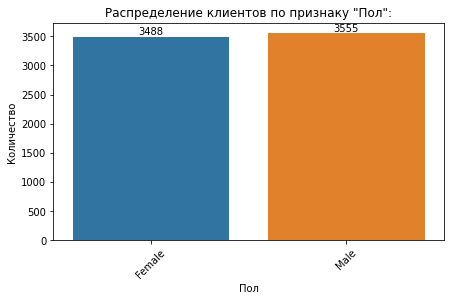

'Из полученных данных видно, что распределение клиентов по признаку "Пол" соотносится в пропорциях'

'Значение признака: Female - 49.5%'

'Значение признака: Male - 50.5%'

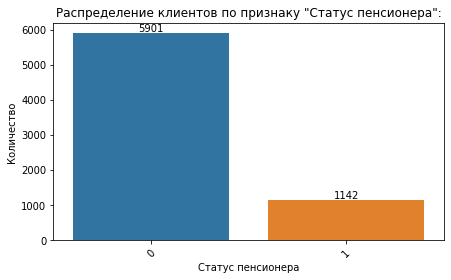

'Из полученных данных видно, что распределение клиентов по признаку "Статус пенсионера" соотносится в пропорциях'

'Значение признака: 0 - 83.8%'

'Значение признака: 1 - 16.2%'

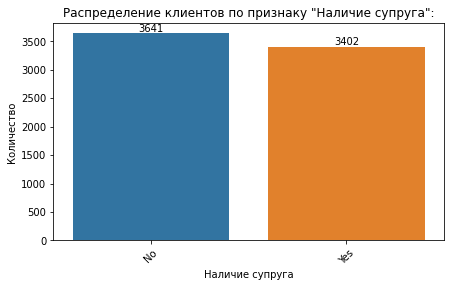

'Из полученных данных видно, что распределение клиентов по признаку "Наличие супруга" соотносится в пропорциях'

'Значение признака: No - 51.7%'

'Значение признака: Yes - 48.3%'

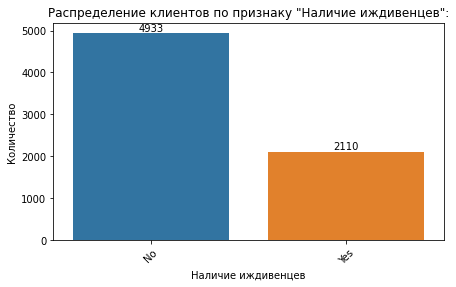

'Из полученных данных видно, что распределение клиентов по признаку "Наличие иждивенцев" соотносится в пропорциях'

'Значение признака: No - 70.0%'

'Значение признака: Yes - 30.0%'

In [10]:
precheck(personal)

Вывод по таблице **personal**  
Пропусков и дубликатов в данных нет.
Распределение данных по признакам "Наличие супруга" и "Пол" примерно одинаковое.
Распределение данных по признакам "Пенсионер" и "Наличие иждевенцев" не одинаковое, имеется дисбаланс.

#### Проведем анализ данных из файла **contract:** 

In [11]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Поменяем тип данных в столбце **BeginDate** на **Datetime**

In [12]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['BeginDate']

0      2020-01-01
1      2017-04-01
2      2019-10-01
3      2016-05-01
4      2019-09-01
          ...    
7038   2018-02-01
7039   2014-02-01
7040   2019-03-01
7041   2019-07-01
7042   2014-08-01
Name: BeginDate, Length: 7043, dtype: datetime64[ns]

'убедимся, что данные прочитаны корректно - выведем первые 5 строк датасета'

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


'Выведем информацию о типе данных и их количетве в каждом столбце'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


'Размер датасета (7043, 8)'

'Количество полных дубликатов - 0 строк'

'Количество дубликатов по значению customerID - 0 строк'

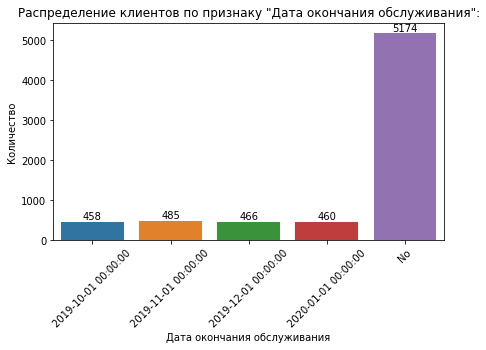

'Из полученных данных видно, что распределение клиентов по признаку "Дата окончания обслуживания" соотносится в пропорциях'

'Значение признака: 2019-10-01 00:00:00 - 6.5%'

'Значение признака: 2019-11-01 00:00:00 - 6.9%'

'Значение признака: 2019-12-01 00:00:00 - 6.6%'

'Значение признака: 2020-01-01 00:00:00 - 6.5%'

'Значение признака: No - 73.5%'

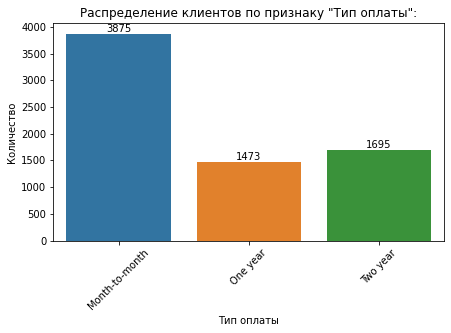

'Из полученных данных видно, что распределение клиентов по признаку "Тип оплаты" соотносится в пропорциях'

'Значение признака: Month-to-month - 55.0%'

'Значение признака: One year - 20.9%'

'Значение признака: Two year - 24.1%'

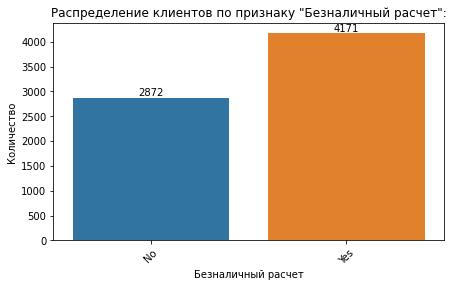

'Из полученных данных видно, что распределение клиентов по признаку "Безналичный расчет" соотносится в пропорциях'

'Значение признака: No - 40.8%'

'Значение признака: Yes - 59.2%'

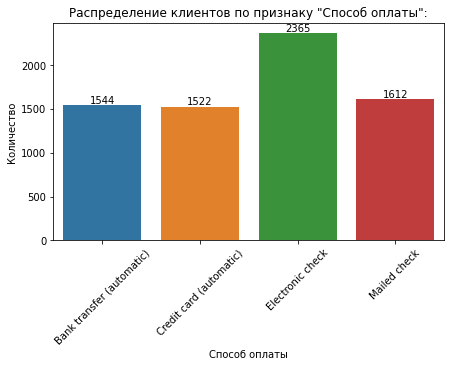

'Из полученных данных видно, что распределение клиентов по признаку "Способ оплаты" соотносится в пропорциях'

'Значение признака: Bank transfer (automatic) - 21.9%'

'Значение признака: Credit card (automatic) - 21.6%'

'Значение признака: Electronic check - 33.6%'

'Значение признака: Mailed check - 22.9%'

In [13]:
precheck(contract)

Рассмотрим подробнее столбец **BeginDate**

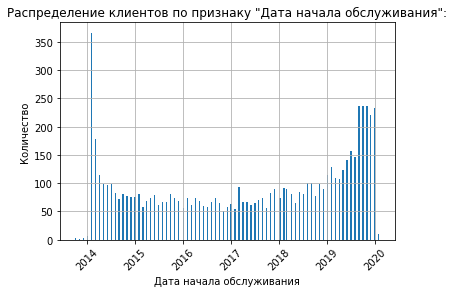

In [14]:
contract['BeginDate'].hist(bins=(contract['BeginDate'].max()-contract['BeginDate'].min()).days // 10)
plt.title(f'Распределение клиентов по признаку "{col_name_dict["BeginDate"]}":')
plt.xlabel(col_name_dict['BeginDate'])
plt.xticks(rotation = 45)
plt.ylabel('Количество')
plt.show()

Рассмотрим подробнее столбец **MonthlyCharges**

Посмотрим основные статистики

In [15]:
contract['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

- Средняя стоимость услуг в месяц составляет 64 условных единицы;
- Медиана 70 условных единиц;
- Минимальная стоимость услуг в месяц - 18 условных единиц;
- Максимальная стоимость услуг в месяц - 118 условных единиц;

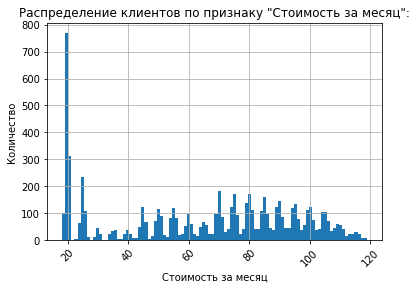

In [16]:
contract['MonthlyCharges'].hist(range=(contract['MonthlyCharges'].min(), contract['MonthlyCharges'].max()),
                              bins = int(contract['MonthlyCharges'].max() - contract['MonthlyCharges'].min()))
plt.title(f'Распределение клиентов по признаку "{col_name_dict["MonthlyCharges"]}":')
plt.xlabel(col_name_dict['MonthlyCharges'])
plt.xticks(rotation = 45)
plt.ylabel('Количество')
plt.show()

Рассмотрим подробнее столбец **TotalCharges**

Переведем данные в столбце к числовому типу данных

In [17]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

Посмотрим основные статистики

In [18]:
contract['TotalCharges'].describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

- Средняя велечина общих затрат на услуги составляет 2283 условных единицы;
- Медиана 1397 условных единиц;
- Минимальная велечина общих затрат на услуги - 18 условных единиц;
- Максимальная  велечина общих затрат на услуги - 8684 условных единиц;

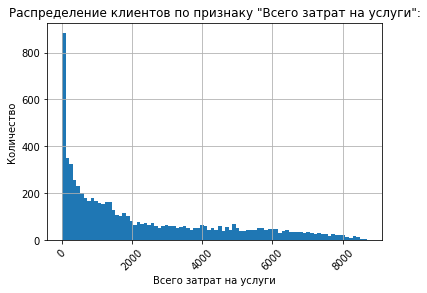

In [19]:
contract['TotalCharges'].hist(range=(contract['TotalCharges'].min(), contract['TotalCharges'].max()),
                              bins = int(contract['TotalCharges'].max() - contract['TotalCharges'].min()) // 100)
plt.title(f'Распределение клиентов по признаку "{col_name_dict["TotalCharges"]}":')
plt.xlabel(col_name_dict['TotalCharges'])
plt.xticks(rotation = 45)
plt.ylabel('Количество')
plt.show()

In [20]:
contract[contract['TotalCharges'] < 100]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
20,8779-QRDMV,2019-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,39.65,39.65
22,1066-JKSGK,2019-11-01,2019-12-01 00:00:00,Month-to-month,No,Mailed check,20.15,20.15
27,8665-UTDHZ,2019-11-01,2019-12-01 00:00:00,Month-to-month,No,Electronic check,30.20,30.20
33,7310-EGVHZ,2020-01-01,No,Month-to-month,No,Bank transfer (automatic),20.20,20.20
...,...,...,...,...,...,...,...,...
7010,0723-DRCLG,2019-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,74.45,74.45
7016,1471-GIQKQ,2020-01-01,No,Month-to-month,No,Electronic check,49.95,49.95
7018,1122-JWTJW,2019-10-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,70.65,70.65
7030,0871-OPBXW,2019-12-01,No,Month-to-month,Yes,Mailed check,20.05,39.25


Вывод по таблице **contract**  
1. Пропусков и дубликатов в данных нет.  
2. Основной объем клиентов компания привлекла в 2014 году. После чего не отмечалось заметного роста притока клиентов. Рост новых клиенов виден начиная с 2019 года. Возможно компания изменила стоимость услуг, условия оплаты, добавила новые продукты и услуги..  
3. Клиенты активно стали уходить в последние 4 месяца. Возможно такие данные из-за ошибок при "сборе" данных. У компании ушло 26,5% клиентов.
4. Около 15% клиентов платят в месяц менее 20 условных единиц. Далее есть "всплески" в районе 25 и 70 условных единиц, после 70 идет снижение.
5. По общим затратам на услуги около 15% клиентов принесли компании менее 100 условных единиц. Из выборки таких клиентов видно, что некоторые клиенты обслужваются 1-2 месяца в компании.

#### Проведем анализ данных из файла **internet:** 

'убедимся, что данные прочитаны корректно - выведем первые 5 строк датасета'

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


'Выведем информацию о типе данных и их количетве в каждом столбце'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


'Размер датасета (5517, 8)'

'Количество полных дубликатов - 0 строк'

'Количество дубликатов по значению customerID - 0 строк'

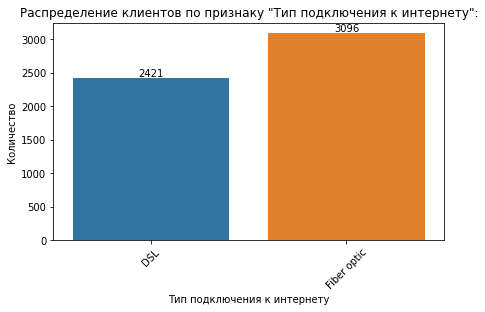

'Из полученных данных видно, что распределение клиентов по признаку "Тип подключения к интернету" соотносится в пропорциях'

'Значение признака: DSL - 43.9%'

'Значение признака: Fiber optic - 56.1%'

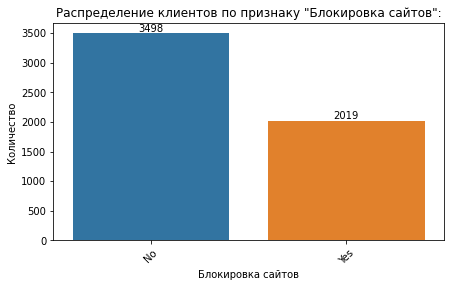

'Из полученных данных видно, что распределение клиентов по признаку "Блокировка сайтов" соотносится в пропорциях'

'Значение признака: No - 63.4%'

'Значение признака: Yes - 36.6%'

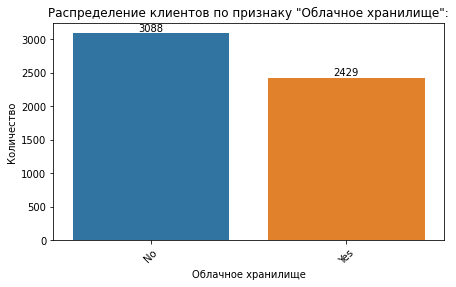

'Из полученных данных видно, что распределение клиентов по признаку "Облачное хранилище" соотносится в пропорциях'

'Значение признака: No - 56.0%'

'Значение признака: Yes - 44.0%'

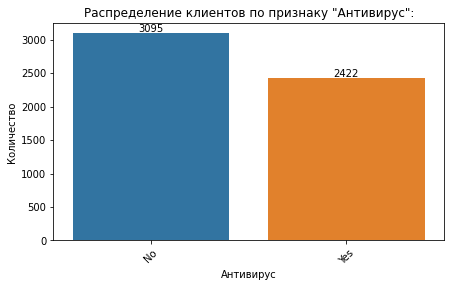

'Из полученных данных видно, что распределение клиентов по признаку "Антивирус" соотносится в пропорциях'

'Значение признака: No - 56.1%'

'Значение признака: Yes - 43.9%'

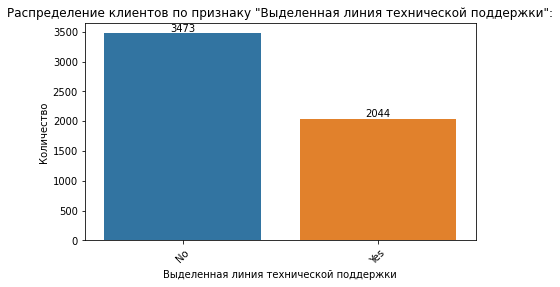

'Из полученных данных видно, что распределение клиентов по признаку "Выделенная линия технической поддержки" соотносится в пропорциях'

'Значение признака: No - 63.0%'

'Значение признака: Yes - 37.0%'

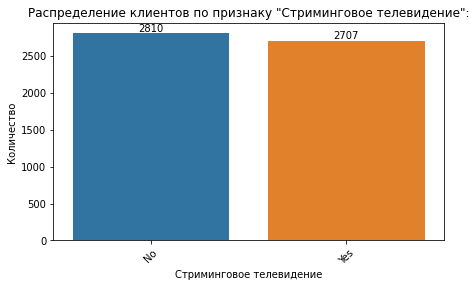

'Из полученных данных видно, что распределение клиентов по признаку "Стриминговое телевидение" соотносится в пропорциях'

'Значение признака: No - 50.9%'

'Значение признака: Yes - 49.1%'

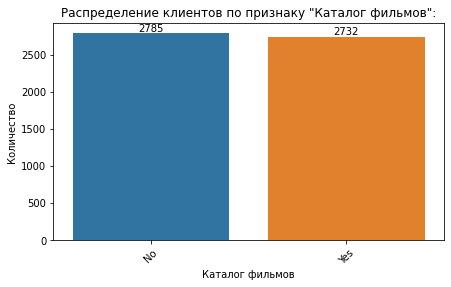

'Из полученных данных видно, что распределение клиентов по признаку "Каталог фильмов" соотносится в пропорциях'

'Значение признака: No - 50.5%'

'Значение признака: Yes - 49.5%'

In [21]:
precheck(internet)

#### Проведем анализ данных из файла **phone:** 

'убедимся, что данные прочитаны корректно - выведем первые 5 строк датасета'

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


'Выведем информацию о типе данных и их количетве в каждом столбце'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


'Размер датасета (6361, 2)'

'Количество полных дубликатов - 0 строк'

'Количество дубликатов по значению customerID - 0 строк'

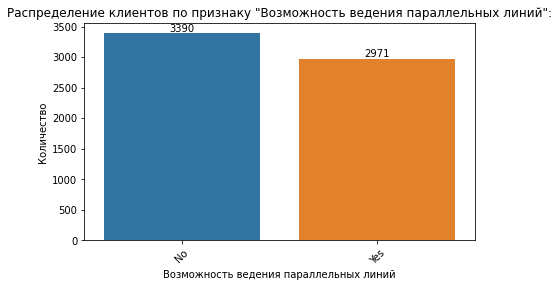

'Из полученных данных видно, что распределение клиентов по признаку "Возможность ведения параллельных линий" соотносится в пропорциях'

'Значение признака: No - 53.3%'

'Значение признака: Yes - 46.7%'

In [22]:
precheck(phone)

### Объединим все датасеты в один 

используем метод присоединения **merge** с присоединением "слева".

In [23]:
df = (
    personal
    .merge(contract, on='customerID', how='left')
    .merge(internet, on='customerID', how='left')
    .merge(phone, on='customerID', how='left')
)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No


Приведем название столбцов к красивому стилю

In [24]:
df = df.rename(columns={'customerID': 'CustomerId', 'gender': 'Gender', 'StreamingTV':'StreamingTv' })

In [25]:
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
df.head()

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No


Проверим, что объединение произошло корректно и названия столбцов переименовались

In [26]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   gender             7043 non-null   object        
 2   senior_citizen     7043 non-null   int64         
 3   partner            7043 non-null   object        
 4   dependents         7043 non-null   object        
 5   begin_date         7043 non-null   datetime64[ns]
 6   end_date           7043 non-null   object        
 7   type               7043 non-null   object        
 8   paperless_billing  7043 non-null   object        
 9   payment_method     7043 non-null   object        
 10  monthly_charges    7043 non-null   float64       
 11  total_charges      7032 non-null   float64       
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

Видно, что при объединении таблиц у нас появились столбцы с пропусками.  
Далее обработаем данные пропуски

приведем тип признака total_charges к числовым данным

In [28]:
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')
df['total_charges']

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: total_charges, Length: 7043, dtype: float64

Проверим пропуски в данных после преобразования

In [29]:
df['total_charges'].isna().sum()

11

Выведем срез из датасета, чтобы понять какие попали клиенты в выборку

In [30]:
df[df['total_charges'].isna()]

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
488,4472-LVYGI,Female,0,Yes,Yes,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,Male,0,No,Yes,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,DSL,No,Yes,Yes,Yes,Yes,No,Yes


Видим, что в столбце **total_charges** - "всего затрачено" на услуги пропуски у клиентов, которые только пришли на обслуживание. Ушедших среди нет, их количество всего 11 клиентов, поэтому удалим эти строки из датасета

In [31]:
df = df[~(df['total_charges'].isna())].reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   index              7032 non-null   int64         
 1   customer_id        7032 non-null   object        
 2   gender             7032 non-null   object        
 3   senior_citizen     7032 non-null   int64         
 4   partner            7032 non-null   object        
 5   dependents         7032 non-null   object        
 6   begin_date         7032 non-null   datetime64[ns]
 7   end_date           7032 non-null   object        
 8   type               7032 non-null   object        
 9   paperless_billing  7032 non-null   object        
 10  payment_method     7032 non-null   object        
 11  monthly_charges    7032 non-null   float64       
 12  total_charges      7032 non-null   float64       
 13  internet_service   5512 non-null   object        
 14  online_s

## Подготовка данных для исследования

### Выделим таргет

Создадим признак "churn", присвоим значение 1 если клиент ушёл и 0 - если не ушёл

In [32]:
df.loc[df['end_date'] == 'No', 'churn'] = 0
df.loc[df['end_date'] != 'No', 'churn'] = 1
target = (df['churn']).astype(int)
target

0       0
1       0
2       1
3       0
4       1
       ..
7027    0
7028    0
7029    0
7030    1
7031    0
Name: churn, Length: 7032, dtype: int32

### Создадим дополнительные признаки для дальнейшего обучения модели

#### Количество дней обслуживания

Для подсчета количества дней в столбце end_date (окончение обслуживания) = No  
Заменим на дату, по которую нам предоставлены данные

In [33]:
df.loc[df['end_date'] == 'No', 'end_date'] = '2020-02-01 00:00:00'
df['end_date']

0       2020-02-01 00:00:00
1       2020-02-01 00:00:00
2       2019-12-01 00:00:00
3       2020-02-01 00:00:00
4       2019-11-01 00:00:00
               ...         
7027    2020-02-01 00:00:00
7028    2020-02-01 00:00:00
7029    2020-02-01 00:00:00
7030    2019-11-01 00:00:00
7031    2020-02-01 00:00:00
Name: end_date, Length: 7032, dtype: object

приведем тип признака day_count к числовому типу

In [34]:
df['day_count'] = (pd.to_datetime(df['end_date']) - pd.to_datetime(df['begin_date'])).dt.days
df['day_count']

0         31
1       1036
2         61
3       1371
4         61
        ... 
7027     730
7028    2191
7029     337
7030     123
7031    2010
Name: day_count, Length: 7032, dtype: int64

Проверим наличие пропусков

In [35]:
df['day_count'].isna().sum()

0

### Проверим корреляцию между признаками

In [36]:
%%time
phik_overview = df.drop(['index', 'customer_id', 'begin_date', 'end_date'], axis=1).phik_matrix()

interval columns not set, guessing: ['senior_citizen', 'monthly_charges', 'total_charges', 'churn', 'day_count']
CPU times: total: 1.34 s
Wall time: 14.3 s


In [37]:
phik_overview.round(2)

,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn,day_count
gender,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
senior_citizen,0.00,1.00,0.02,0.32,0.09,0.24,0.29,0.30,0.15,0.31,0.17,0.00,0.00,0.21,0.05,0.07,0.24,0.23,0.03
partner,0.00,0.02,1.00,0.65,0.18,0.01,0.24,0.20,0.42,0.00,0.26,0.27,0.29,0.22,0.24,0.23,0.23,0.23,0.49
dependents,0.00,0.32,0.65,1.00,0.15,0.17,0.22,0.18,0.12,0.20,0.24,0.15,0.13,0.21,0.08,0.03,0.04,0.25,0.21
type,0.00,0.09,0.18,0.15,1.00,0.11,0.28,0.39,0.51,0.11,0.25,0.20,0.25,0.29,0.16,0.17,0.07,0.25,0.67
paperless_billing,0.00,0.24,0.01,0.17,0.11,1.00,0.37,0.47,0.21,0.36,0.22,0.00,0.03,0.14,0.18,0.16,0.27,0.30,0.00
payment_method,0.00,0.29,0.24,0.22,0.28,0.37,1.00,0.40,0.35,0.43,0.36,0.27,0.30,0.37,0.25,0.26,0.37,0.45,0.37
monthly_charges,0.01,0.30,0.20,0.18,0.39,0.47,0.40,1.00,0.76,0.95,0.36,0.43,0.50,0.40,0.73,0.73,0.48,0.36,0.41
total_charges,0.00,0.15,0.42,0.12,0.51,0.21,0.35,0.76,1.00,0.35,0.44,0.56,0.58,0.47,0.55,0.56,0.61,0.28,0.84
internet_service,0.00,0.31,0.00,0.20,0.11,0.36,0.43,0.95,0.35,1.00,0.34,0.00,0.00,0.33,0.26,0.25,0.34,0.37,0.00


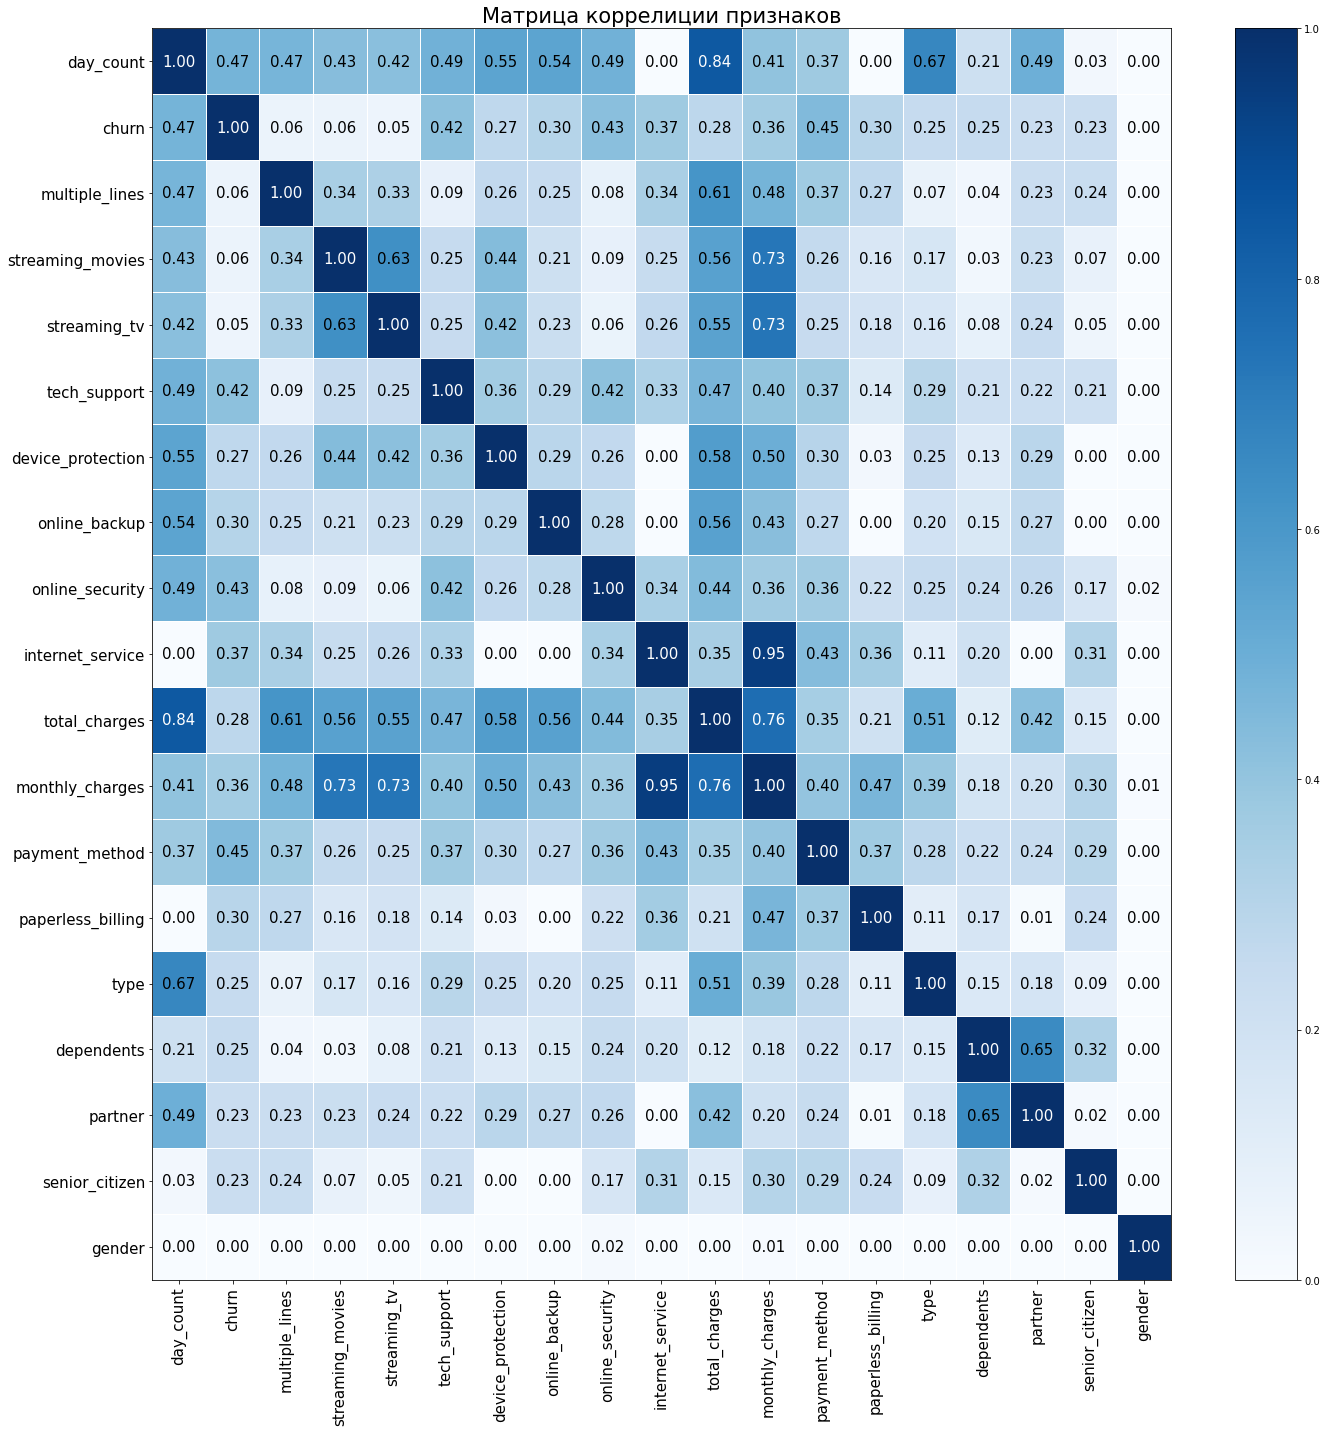

In [38]:
plot_correlation_matrix(phik_overview.values,
                       x_labels=phik_overview.columns,
                       y_labels=phik_overview.index,
                       vmin=0, vmax=1, color_map="Blues",
                       title = 'Матрица коррелиции признаков',
                       fontsize_factor=1.5,
                       figsize=(20,20))

Из матрицы корелляции видно, что признак **gender** не влияет ни на один из других признаков.
Сильная мультиколлинеарность у признака **total_charges** с признаками: *day_counts, month_charges*. Удалим признак **total_charges**  
**gender** не имеют никакой корелляции с целевым признаком - удалим их и не будем учитывать при обучении модели

In [39]:
df.drop(['index','gender', 'total_charges','customer_id', 'begin_date', 'end_date'], axis=1, inplace=True)

### Визуализация отличия клиентов в зависимости от целевого признака

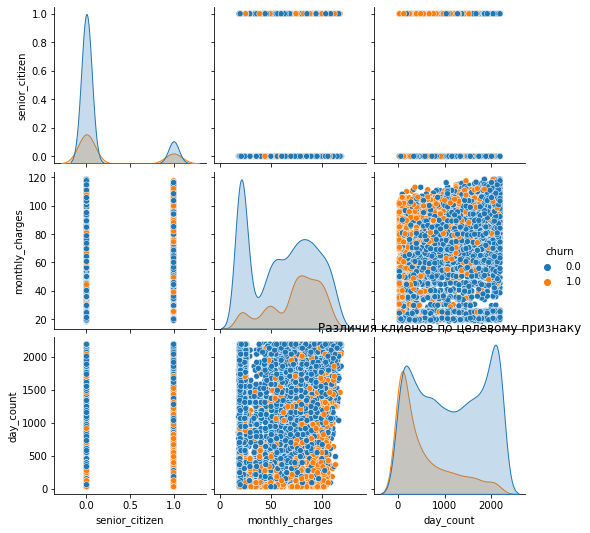

In [40]:
sns.pairplot(data = df, hue='churn')
plt.title('Различия клиенов по целевому признаку')
plt.show()

Из графика видно, по признаку **пенсионер:**
- 50% пенсионеров уходят из компании;
- у пенсионеров выше средний "чек" оплаты за подключенные услуги;
- пенсионеры дольше являются клиентами компании (что в принципе логично).

По признаку **ежемесячная стоимость услуг:**
- среди "маленьких" чеков отток клиентов не сильно заметен. Но колество ушедших среди клиентов с "крупным" чеком имеет сильную выраженность;

по признаку **количество дней обслуживания:**
- отток очень сильно заметен среди клиентов, которые обслуживаются небольшое количество дней. 
- при "долгом" обслуживании в компании отток значительно уменьшается.

### Выделим признаки, на которых будет обучаться модель

In [41]:
features = df.drop('churn', axis=1)

In [42]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   senior_citizen     7032 non-null   int64  
 1   partner            7032 non-null   object 
 2   dependents         7032 non-null   object 
 3   type               7032 non-null   object 
 4   paperless_billing  7032 non-null   object 
 5   payment_method     7032 non-null   object 
 6   monthly_charges    7032 non-null   float64
 7   internet_service   5512 non-null   object 
 8   online_security    5512 non-null   object 
 9   online_backup      5512 non-null   object 
 10  device_protection  5512 non-null   object 
 11  tech_support       5512 non-null   object 
 12  streaming_tv       5512 non-null   object 
 13  streaming_movies   5512 non-null   object 
 14  multiple_lines     6352 non-null   object 
 15  day_count          7032 non-null   int64  
dtypes: float64(1), int64(2),

In [43]:
target.count()

7032

### Разделим данные на тренировочную и тестовую выборки

In [44]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size = 0.25,
                                                                            random_state=RANDOM_STATE,
                                                                            stratify=target)

In [45]:
display(f'размер тренировочной выборки {target_train.shape[0]} строк,',
        f'количество строк с классом=1 в целевом признаке {target_train.sum()}'
       )

'размер тренировочной выборки 5274 строк,'

'количество строк с классом=1 в целевом признаке 1402'

In [46]:
display(f'размер тренировочной выборки {features_test.shape[0]} строк,',
        f'количество строк с классом=1 в целевом признаке {target_test.sum()}')

'размер тренировочной выборки 1758 строк,'

'количество строк с классом=1 в целевом признаке 467'

## Выбор и обучение модели (реализация с использованием PIPELINE)

In [47]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5274 entries, 2389 to 3455
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   senior_citizen     5274 non-null   int64  
 1   partner            5274 non-null   object 
 2   dependents         5274 non-null   object 
 3   type               5274 non-null   object 
 4   paperless_billing  5274 non-null   object 
 5   payment_method     5274 non-null   object 
 6   monthly_charges    5274 non-null   float64
 7   internet_service   4132 non-null   object 
 8   online_security    4132 non-null   object 
 9   online_backup      4132 non-null   object 
 10  device_protection  4132 non-null   object 
 11  tech_support       4132 non-null   object 
 12  streaming_tv       4132 non-null   object 
 13  streaming_movies   4132 non-null   object 
 14  multiple_lines     4773 non-null   object 
 15  day_count          5274 non-null   int64  
dtypes: float64(1), int64(

### Выделим числовые и строковые типы столбцов

In [48]:
num_columns_selector = selector(dtype_exclude='object') #все кроме типа object
cat_columns_selector = selector(dtype_include='object') #все, которые имеют тип object

numerical_columns = num_columns_selector(features)
categorical_columns = cat_columns_selector(features)

### Напишем функцию заполнения пропусков. 

Будем считать, что есть в столбце пропуск - значит клиент не пользуется услугой. В таком случае будем заполнять значение 'No'

In [49]:
def fill_no(data):
    for column in data.columns.to_list():
        data[data[column].isna()] = 'No'
    return data

"Обвернем" фукцию в трансформер для использования в Пайплайне

In [50]:
fill_no_estimator = FunctionTransformer(fill_no)

### Создание пайплайна

Создадим 2 пайплайна:
- для числовых признаков: применим стандартизацию.
- для категориальных признаков: 
    - заполним пропуски;
    - закодируем категориальные признаки с помощью **OneHotEncoder**

In [51]:
num_pipeline = Pipeline([('scaler', StandardScaler())])
cat_pipeline = Pipeline([('fill_no', FunctionTransformer(fill_no)),
                        ('cat_encoder', OneHotEncoder(drop='first',handle_unknown='ignore', sparse=False))])
col_pipeline = ColumnTransformer([('num_cols', num_pipeline, numerical_columns),
                                  ('cat_encoder',cat_pipeline, categorical_columns)],
                                remainder='passthrough')
col_pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_cols',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['senior_citizen', 'monthly_charges',
                                  'day_count']),
                                ('cat_encoder',
                                 Pipeline(steps=[('fill_no',
                                                  FunctionTransformer(func=<function fill_no at 0x0000017D62FD80D0>)),
                                                 ('cat_encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['partner', 'dependents', 'type',
                                  'paperless_billing', 'payment_method',
                             

In [52]:
pipeline = make_pipeline(col_pipeline)
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_cols',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['senior_citizen',
                                                   'monthly_charges',
                                                   'day_count']),
                                                 ('cat_encoder',
                                                  Pipeline(steps=[('fill_no',
                                                                   FunctionTransformer(func=<function fill_no at 0x0000017D62FD80D0>)),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(drop='first',
              

### Добавим в пайплайн модель DummyClassifier

In [53]:
pipeline.steps.append(('clf', DummyClassifier(random_state=42)))
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_cols',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['senior_citizen',
                                                   'monthly_charges',
                                                   'day_count']),
                                                 ('cat_encoder',
                                                  Pipeline(steps=[('fill_no',
                                                                   FunctionTransformer(func=<function fill_no at 0x0000017D62FD80D0>)),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(drop='first',
              

### RandomizedSearchCV: Подбор наилучших параметров моделей 

In [54]:
estimators_range = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)]
max_depth_range = [int(x) for x in np.linspace(start = 1, stop = 15, num = 5)]

params = [
    {
    'clf' : [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', tol=0.01)],
    'clf__solver' : ['liblinear'],
    'clf__penalty' : ['l1', 'l2'],
    'clf__C' : [0.1, 0.5, 1]
    },

    
    {
    'clf' : [CatBoostClassifier(random_state=RANDOM_STATE, verbose=50, auto_class_weights='Balanced')],
    'clf__n_estimators': estimators_range,
    'clf__max_depth': max_depth_range,
    'columntransformer__num_cols__scaler': [None]
    },
    
    
    {
    'clf' : [RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced')],
    'clf__n_estimators' : [2,10,100],
    'clf__max_depth' : [3,5,10,15],
    'clf__max_features' : [None, 'sqrt', 'log2'],
    'columntransformer__num_cols__scaler': [None]
    },   

]

grid = RandomizedSearchCV(pipeline,
                         params,
                         n_iter=30,
                         cv=5,
                         verbose=1,
                         random_state=RANDOM_STATE,
                         scoring='roc_auc', 
                         n_jobs=-1)

In [55]:
%%time

grid.fit(features_train, target_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Learning rate set to 0.079071
0:	learn: 0.6671693	total: 157ms	remaining: 36.7s
50:	learn: 0.4587109	total: 654ms	remaining: 2.36s
100:	learn: 0.4306086	total: 1.16s	remaining: 1.53s
150:	learn: 0.4024622	total: 1.66s	remaining: 924ms
200:	learn: 0.3754275	total: 2.16s	remaining: 366ms
234:	learn: 0.3600509	total: 2.51s	remaining: 0us
CPU times: total: 8.05 s
Wall time: 38min 30s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num_cols',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['senior_citizen',
                                                                                'monthly_charges',
                                                                                'day_count']),
                                                                              ('cat_encoder',
                                                                               Pipeline(steps=[('fill_no',
            

### Лучшая модель

Выведем информацию о лучшей модели

In [56]:
grid.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_cols',
                                                  Pipeline(steps=[('scaler',
                                                                   None)]),
                                                  ['senior_citizen',
                                                   'monthly_charges',
                                                   'day_count']),
                                                 ('cat_encoder',
                                                  Pipeline(steps=[('fill_no',
                                                                   FunctionTransformer(func=<function fill_no at 0x0000017D62FD80D0>)),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(drop='first',
                          

Выведем гиперпараметры для "лучшей" модели, подобранные на кроссвалидации

In [57]:
grid.best_params_

{'columntransformer__num_cols__scaler': None,
 'clf__n_estimators': 235,
 'clf__max_depth': 4,
 'clf': <catboost.core.CatBoostClassifier at 0x17d62fe53d0>}

Выведем таблицу, в которой отразим результаты кроссвалидации
В столбцах:
- **mean_test_score** указывается средний результат метрики **roc_auc** по всем прогонам;
- **std_test_score** указывается стандартное отклонение;
- **mean_fit_time** среднее время обучение модели.

In [58]:
cv_results = pd.DataFrame(grid.cv_results_)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results[['params','param_clf', 'rank_test_score', 'mean_test_score', 'std_test_score','mean_fit_time']].head(10)

,params,param_clf,rank_test_score,mean_test_score,std_test_score,mean_fit_time
27,"{'columntransformer__num_cols__scaler': None, ...",<catboost.core.CatBoostClassifier object at 0x...,1,0.888200,0.008915,5.388442
10,"{'columntransformer__num_cols__scaler': None, ...",<catboost.core.CatBoostClassifier object at 0x...,2,0.887911,0.008351,3.179785
6,"{'columntransformer__num_cols__scaler': None, ...",<catboost.core.CatBoostClassifier object at 0x...,3,0.887771,0.008954,6.227987
5,"{'columntransformer__num_cols__scaler': None, ...",<catboost.core.CatBoostClassifier object at 0x...,4,0.886786,0.010257,16.393319
28,"{'columntransformer__num_cols__scaler': None, ...",<catboost.core.CatBoostClassifier object at 0x...,5,0.885916,0.010281,9.388383
18,"{'columntransformer__num_cols__scaler': None, ...",<catboost.core.CatBoostClassifier object at 0x...,6,0.885598,0.009266,9.504171
12,"{'columntransformer__num_cols__scaler': None, ...",<catboost.core.CatBoostClassifier object at 0x...,7,0.869924,0.012000,28.350333
25,"{'columntransformer__num_cols__scaler': None, ...",<catboost.core.CatBoostClassifier object at 0x...,8,0.869810,0.009861,90.067274
19,"{'columntransformer__num_cols__scaler': None, ...",<catboost.core.CatBoostClassifier object at 0x...,9,0.868891,0.010060,48.506407
21,"{'columntransformer__num_cols__scaler': None, ...",<catboost.core.CatBoostClassifier object at 0x...,10,0.858141,0.011235,948.805006


Из полученных данных видно, что наилучший результат на тренировочной выборке показала модель, что сопадает с значением best_params_

In [59]:
cv_results[['params']].head(1).values

array([[{'columntransformer__num_cols__scaler': None, 'clf__n_estimators': 235, 'clf__max_depth': 4, 'clf': <catboost.core.CatBoostClassifier object at 0x0000017D62FE53D0>}]],
      dtype=object)

**Вывод по блоку обучения модели**  
Процесс обучения модели был реализован с использования метода RandomizedSearchCV, в котором с использованием кросс-валидации были подобраны оптимальные параметры и лучшая модель машинного обучения для данной задачи.  
В результате получили следующие значения метрик:

In [60]:
display(f'Метрика roc_auc имеет значение {float(cv_results["mean_test_score"].head(1).values):.3f}.')
display(f'Стандартное отклонение {float(cv_results[["std_test_score"]].head(1).values):.4f}.')
display(f'время обучения {float(cv_results[["mean_fit_time"]].head(1).values):.2f} секунды.')

'Метрика roc_auc имеет значение 0.888.'

'Стандартное отклонение 0.0089.'

'время обучения 5.39 секунды.'

Если бы задача была на оптимизацию скорости обучения модели могли бы использовать другие гиперпараметры или модель машинного обучения, но целевая метрика **roc_auc** была бы ниже

## Проверка лучший модели на тестовых данных

### Сделаем предсказания

In [61]:
predict = grid.predict(features_test)
predict

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

### Посчитаем метрику roc_auc для лучшей модели:

In [62]:
roc_auc = roc_auc_score(target_test, grid.predict_proba(features_test)[:,1])
f' Значение метрики roc_auc равно {roc_auc}'

' Значение метрики roc_auc равно 0.8937314333957542'

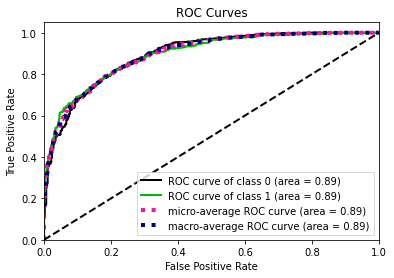

In [63]:
skplt.metrics.plot_roc_curve(target_test, grid.predict_proba(features_test))
plt.show()

### Посчитаем значение метрики accuracy

In [64]:
accuracy = accuracy_score(target_test, predict)
f' Значение метрики accuracy равно {accuracy}'

' Значение метрики accuracy равно 0.8014789533560864'

In [65]:
confusion_matrix(target_test,predict)

array([[1037,  254],
       [  95,  372]], dtype=int64)

### Выведем матрицу ошибок

In [66]:
matrix_epic(target_test,predict)

'Истинно негативные - 1037 предсказаний (клиенты не уйдут из банка)'

'Ложно позиивные - 254 предсказаний (мы предсказали, что клиенты уйдут, но ошиблись!)'

'Ложно негативные - 95 предсказаний (мы предсказали, что клиенты не уйдут, но ошиблись!)'

'Истинно позитивные - 372 предсказаний (клиенты уйдут из банка)'

array([[1037,  254,   95,  372]], dtype=int64)

In [110]:
model_feature_impotances = grid.best_estimator_.steps[1][1].feature_importances_
model_feature_impotances

array([ 0.9725356 ,  8.11616373, 72.93417343,  0.08426365,  0.32455687,
        0.37828426,  1.43427575,  2.26312247,  1.08173108,  0.2402778 ,
        1.22006193,  0.64366235,  0.34586455,  5.962258  ,  0.17336999,
        0.64630143,  0.28556608,  0.12526155,  0.75645722,  0.41435893,
        0.77947169,  0.81798161])

In [113]:
fill_na = grid.best_estimator_.named_steps["columntransformer"].transformers[1][1][0]
fill_na

FunctionTransformer(func=<function fill_no at 0x0000017D62FD80D0>)

In [114]:
ohe = grid.best_estimator_.named_steps["columntransformer"].transformers[1][1][1]
ohe

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [115]:
feature_after_transform = fill_na.fit_transform(features_train[categorical_columns])
feature_after_transform

,partner,dependents,type,paperless_billing,payment_method,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
2389,No,No,One year,Yes,Credit card (automatic),Fiber optic,No,Yes,No,No,No,No,Yes
2237,No,No,No,No,No,No,No,No,No,No,No,No,No
2726,No,No,Month-to-month,No,Credit card (automatic),Fiber optic,Yes,Yes,Yes,No,Yes,Yes,Yes
782,No,No,No,No,No,No,No,No,No,No,No,No,No
6980,No,No,Month-to-month,No,Bank transfer (automatic),Fiber optic,No,No,No,No,Yes,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,No,No,No,No,No,No,No,No,No,No,No,No,No
3902,No,No,No,No,No,No,No,No,No,No,No,No,No
662,Yes,Yes,Two year,Yes,Mailed check,DSL,Yes,Yes,No,No,No,Yes,Yes
4123,No,No,No,No,No,No,No,No,No,No,No,No,No


In [116]:
feature_after_transform = ohe.fit_transform(feature_after_transform)
feature_after_transform

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 0., ..., 0., 1., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]])

In [122]:
feature_names_after_transform = ohe.get_feature_names_out().tolist()

In [123]:
feature_names_after_transform = numerical_columns + feature_names_after_transform
feature_names_after_transform

['senior_citizen',
 'monthly_charges',
 'day_count',
 'partner_Yes',
 'dependents_Yes',
 'type_No',
 'type_One year',
 'type_Two year',
 'paperless_billing_Yes',
 'payment_method_Credit card (automatic)',
 'payment_method_Electronic check',
 'payment_method_Mailed check',
 'payment_method_No',
 'internet_service_Fiber optic',
 'internet_service_No',
 'online_security_Yes',
 'online_backup_Yes',
 'device_protection_Yes',
 'tech_support_Yes',
 'streaming_tv_Yes',
 'streaming_movies_Yes',
 'multiple_lines_Yes']

In [128]:
df_features = pd.DataFrame(data=model_feature_impotances, index=feature_names_after_transform, columns=['Важность'])
df_features.sort_values(by = 'Важность', ascending=False, inplace=True)
df_features

,Важность
day_count,72.934173
monthly_charges,8.116164
internet_service_Fiber optic,5.962258
type_Two year,2.263122
type_One year,1.434276
payment_method_Electronic check,1.220062
paperless_billing_Yes,1.081731
senior_citizen,0.972536
multiple_lines_Yes,0.817982
streaming_movies_Yes,0.779472


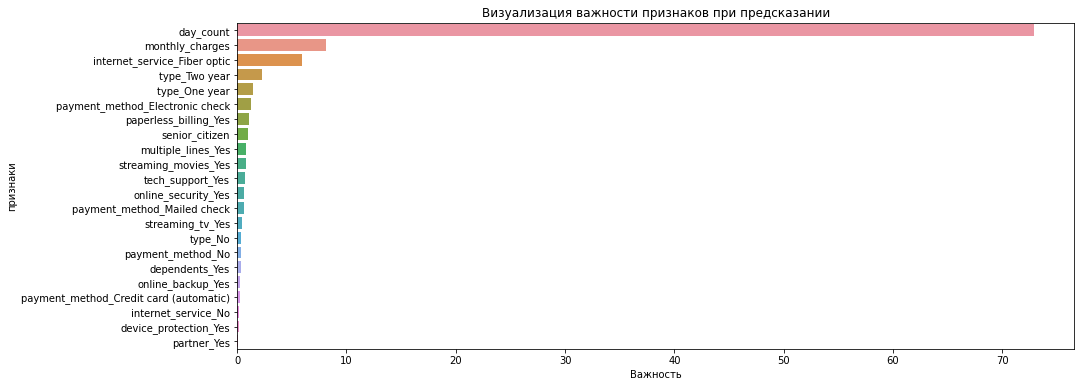

In [133]:
plt.figure(figsize=(15,6))
sns.barplot(data=df_features, x='Важность', y=df_features.index)
plt.ylabel('признаки')
plt.title('Визуализация важности признаков при предсказании')
plt.show()

Из графика видим, что самый важный признак - количество дней обслуживания.  
На втором месте - ежемесячная плата за услуги.  
На третьем - тип подключения к интернету.

## Вывод

Перед оператором связи стояла задача научиться прогнозировать отток клиенов.  
На основе имеющихся данных о клиентах и имеющимися у них услугами необходимо было предсказать склонен ли клиент к оттоку или нет.  
Если компания поймет, что клиент склонен к оттоку ему будут предложены промокоды и специальные условия обслуживания.

В результате решения задачи мы получили следующие метрики:

In [134]:
display(f' Значение метрики roc_auc равно {roc_auc}')
display(f' Значение метрики accuracy равно {accuracy}')
data = matrix_epic(target_test,predict)

' Значение метрики roc_auc равно 0.8937314333957542'

' Значение метрики accuracy равно 0.8014789533560864'

'Истинно негативные - 1037 предсказаний (клиенты не уйдут из банка)'

'Ложно позиивные - 254 предсказаний (мы предсказали, что клиенты уйдут, но ошиблись!)'

'Ложно негативные - 95 предсказаний (мы предсказали, что клиенты не уйдут, но ошиблись!)'

'Истинно позитивные - 372 предсказаний (клиенты уйдут из банка)'

С поставленной задачей получить метрику roc_auc > 0.85 справились успешно

### Дополнительные выводы для бизнеса

Из 1758 клиентах, которые находились в тестовой выборке было 467 клиентов, которые ушли из Банка.
Модели получилось правильно предсказать отток 383 клиентов, что составляет 82% от всех ушедших клиентов

In [135]:
f'Cредняя плата за услуги среди клиентов, которые ушли составляет {df.loc[df["churn"]==1, "monthly_charges"].mean()}'

'Cредняя плата за услуги среди клиентов, которые ушли составляет 74.4413322632423'

In [136]:
display(
    f'Таким образом, вовремя предприняв возможные усилия, компания могла бы не упустить '
    f'{float(data[0][3]*(df.loc[df["churn"]==1, "monthly_charges"].mean())):.2f} условых единиц в месяц'
)

'Таким образом, вовремя предприняв возможные усилия, компания могла бы не упустить 27692.18 условых единиц в месяц'

! *в расчет принимался только средний доход клиентов, без учета расходов на скидку или "специальные условия для них и для тех, кому мы дали скидку, хотя они не собирались уходить*

## Отчет

<p style="text-align: center;">
<br>Тема работы "Прогнозирование оттока клиентов"  
<br>Серов Дмитрий  
<br>Яндекс Практикум. Когорта DS_51  
<br>05/04/2023  </p>

В данном проекте мы исследовали проблему классифкации оттока клиента используя данные компании «Ниединогоразрыва.ком». Наш алгоритм пытается предсказать уйдет клиент из банка или нет. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.  
Представленная в проекте модель обучения основана на подборе лучшей модели с наилучшими гиперпараметрами.  
Среди моделей рассматривались:  
**- Логистическая регрессия;**  
**- Случайный лес;**  
**- CatBoost.**  

Благодаря рассмотрению нескольких моделей и подбору гиперпараметров мы смогли получить значения метрик на тестовых данных:  
**- roc_auc – 0,89;**  
**- accuracy – 0,80.**  


# Введение
В период высокой конкуренции за клиента компании вынуждены разрабатывать программы лояльности или предоставление скидок клиентам, которые позволят удерживать клиентов.  
Задача компании на основе имеющихся данных о пользователях и об услугах, которыми клиент пользуется предсказать склонность клиента к оттоку. 
Привлечение новых клиентов зачастую связано с большой статьей расходов. При этом вновь привлеченный клиент зачастую не готов заключать сразу же долгосрочный контракт, а оплачивает помесячно. В связи с этим есть риск оттока этого клиента в первые месяцы
В свою очередь удержание клиентов за счет предоставления скидки позволяет компании сохранить клиентскую базу при незначительном объеме недополученного дохода, но при этом сохранить лояльность клиента.  

# План проекта  

Перед выполнением проекта был определен план, который предполагал последовательность действий для исследования и обработки данных, подготовке для использования при обучении и тестировании.  
План состоял из 6 блоков, которые в свою очередь разбивались на подзадачи:  

**Загрузка данных и проверка на корректную загрузку и объединение в один датафрейм:**  
1. Знакомство с данными: head, info, describe, duplicated..;
2. Проведение анализа данных, изменение типов данных, приведение данных к "змеиному" стилю;
3. Построение графиков, чтобы посмотреть распределение и соотношение признаков среди пользователей;
4. Объединение таблиц;
5. Выделение целевого признака.
6. Создание новых признаков для дальнейшего использования в модели;

**Проверка данных на корреляцию:**  
1. Анализ полученных результатов;
2. Удаление признаков, которые имеют высокую корреляцию между собой и с целевым признаком.

**Исследовательский анализ данных и подготовка данных к обучению:**  
1. Проверка на пропуски, обработка пропусков;
2. Разбиение данных на выборки: тренировочную и тестовую;
3. Стандартизация числовых данных;
4. Кодирование категориальных данных;

**Выбор и обучение моделей:**  
1. Выбор моделей для обучения: **логистическая регрессия, случайный лес, CatBoost/LightGMB**;
2. Подбор гиперпараметров **RandomizeSearchCV**;
3. Обучение моделей и предсказания на тренировочных данных;
4. Определение лучшей модели и лучших гиперпараметров по целевой метрике.

**Проверка лучшей модели на тестовых данных**  

**Интерпритация полученных результатов:**  
1. Какое значение метрики получили;
2. Какие признаки являются наиболее важными в определении класса пользователя;
3. Какого убытка получится избежать при внеднении модели.

<span style="color:green"><b>В результате выполнения проекта все пункты из изначального плана были выполнены.</b></span>


# Решение

Разберем каждый из блоков отдельно  

<font size=4><b>Загрузка данных и проверка на корректную загрузку и объединение в один датафрейм: </b></font>

**1.	Знакомство с данными: head, info, describe, duplicated..**  
Первоначально мы загрузили данные, убедились, что данные корректно считаны и ознакомились с типами данных и непосредственно с самими данными.  
Была выполнена проверка на наличие полных дубликатов и дубликатов по идентификатору пользователя в каждой таблице.
Для знакомства с данными была написана функция precheck, которая получая датасет выводила информацию о датасете, размеры и также выполняла исследовательский анализ.  

**2.	Проведение анализа данных, изменение типов данных, приведение данных к "змеиному" стилю.**  
В результате анализа и предобработки данных были изменены типы данных в столбцах:  
- **TotalCharges** – к числовому типу **float;**    
- **BeginDate** – к типу **Datetime.**  

    Названия привели к змеиному стилю после объединения таблиц.  

**3.	 Построение графиков, чтобы посмотреть распределение и соотношение признаков среди пользователей.**  
По каждому признаку вывели график и соотношение долей распределения, чтобы понять как  клиенты отличаются друг от друга.  

**4.	Объединение таблиц.**  
Объединение таблиц провели по признаку **customer_id**, т.к. это уникальный идентификатор клиента, который фигурирует в каждой таблице.   
В результате объединения, в датасете появились пропуски в признаках связанных с видами подключенных услуг. В дальнейшем мы отработаем данные пропуски.  

**5.	Выделение целевого признака.**  
При выделение целевого признака – ушёл клиент из компании или нет взяли признак **EndDate**. Если дата заполнена – клиент ушёл. Если пустая – клиент еще обслуживается в компании.  

**6.	Создание новых признаков для дальнейшего использования в модели.**  
При анализе датасета было принято создать новый признак – количество дней обслуживания клиента в компании. Для этого мы вычли из даты завершения обслуживания дату начала. У клиентов, которые дата завершения отсутствовала – указали дату окончания дату, на которую предоставлены данные.  
Помимо создания новых признаков из датасета были удалены малоинформативные признаки: **index, gender, customer_id.**  
Также были удалены признаки:  
- begin_date – модель могла использовать этот признак и обучаться некорректно.  
- end_date – прямая связь с целевым признаком. Нельзя допустить утечки целевого признака.  



<font size=4><b> Проверка данных на корреляцию: </b></font>  

Проверку на корреляцию проводили, используя метод **phik**. Данный метод позволяет искать нелинейную корреляцию и учитывает категориальные признаки.  

**1.	Анализ полученных результатов.**  
В ходе анализа таблицы корреляции была выявлена сильная прямая корреляция между числовым признаком: **total_charges** и **day_counts, month_charges.** А также полное отсутствие корелляции признака **gender** с целевым признаком.  

**2.	Удаление признаков, которые имеют высокую корреляцию между собой и с целевым признаком.**  
В результате анализа были удалены из датасета следующие признаки. total_charges и gender.  

Дополнительно построили визуализацию различия клиентов по признакам в зависимости от распределения целевого с помощью **sns.pairplot.**  

<font size=4><b> Исследовательский анализ данных и подготовка данных к обучению: </b></font>  

**1.	Проверка на пропуски, обработка пропусков.**  
Пропуски были двух типов:  
- клиенты, которые не имели значения в столбце total_charges. Таких клиентов было всего 11, и мы удалили эти строки датасета.
- пропуски в признаках, которые соответсвуют типу услуги, которая подключена у клиента. В результате анализа был сделан вывод, что, если в столбце пропуск, значит клиент не пользуется данной услугой.  

Для обработки пропусков была написана функция **fill_no**, которая проходила по столбцам датасета и там, где находила пропуск – заполняла значением **‘No’**. Данная функция была «обернута» в транформер и включена в Пайплайн.  

**2.	Разбиение данных на выборки: тренировочную и тестовую.**  
Произвели разбиение данных на тренировочную и тестовую выборку используя **train_test_split.**  
Установили значения параметров:  
- **test_size** = 0.25 (размер тестовой выборки);  
- **random_state** = 27032023.


Далее мы получили перечень признаков, на которых обучали модель:
**senior_citizen, monthly_charges, day_count, partner, dependents, type, paperless_billing, payment_method, internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, multiple_lines**

После чего разделили признаки на числовые и категориальные.

**3.	Стандартизация числовых данных.**  
Произвели масштабирование числовых признаков **senior_citizen, monthly_charge, day_count**, используя **StandardScaler().**  

**4. Кодирование категориальных данных.**  
Над категориальными признаками **partner, dependents, type, paperless_billing, payment_method, internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, multiple_lines**  
производили 2 преобразования:
- сначала заполнили пропуски значениями ‘No’ c помощью функции fill_no;
- после чего закодировали категориальные признаки **OneHotEncoder()**. Использовали параметры drop='first', handle_unknown='ignore', sparse=False.

Кодирование признаков производили в Пайплайне, куда в дальнейшем встроили **RandomizedSearchCV.**  

<font size=4><b> Выбор и обучение моделей: </b></font>  

**1.	Выбор моделей для обучения:**   
Для обучения рассматривали 3 модели машинного обучения:  
- Логистическая регрессия;  
- Случайный лес;  
- CatBoost.  

**2.	Подбор гиперпараметров **RandomizeSearchCV.**  
В RandomizeSearchCV были рассмотрены разные комбинации гиперпараметров и произведена кроссвалицадация на 5 фолдах, каждая по 30 итераций.  

**3.	Обучение моделей и предсказания на тренировочных данных.**  

**4. Определение лучшей модели и лучших гиперпараметров по целевой метрике.**  
В результате обучения на тренировочных данных лучшую метрику **roc_auc** равную **0.88** совместно со стандартным отклонением **0.0089** показала модель **CatBoost.**  

**RandomizedSearchCV** подобрала лучшие гиперпараметры:   
- columntransformer__num_cols__scaler: None,  
- clf__n_estimators: 235,  
- clf__max_depth: 4.  

<font size=4><b> Проверка лучшей модели на тестовых данных: </b></font>  

Значение метрики **roc_auc** на тестовых данных получили равной **0.893.**  
Значение метрики **accuracy** равную **0.80.**  

Построили матрицу ошибок:  
**Истинно негативные - 1037 предсказаний** (клиенты не уйдут из банка);  
**Ложно позиивные - 254 предсказаний** (мы предсказали, что клиенты уйдут, но ошиблись!);  
**Ложно негативные - 95 предсказаний** (мы предсказали, что клиенты не уйдут, но ошиблись!);  
**Истинно позитивные - 372 предсказаний** (клиенты уйдут из банка).  

Таких результатов получилось достич из за качественного подбора признаков, на которых обучалась модель.  
Самым важным признаком получился созданный нами: **количетсво дней обслуживания.**  

Дополнительно отмечу, что используя **RandomizeSearchCV** и встроенную в него кроссвалидацию получилось подобрать наилучшую модель машинного обучения с лучшим набором гиперпараметров.  

<font size=4><b> Интерпритация полученных результатов: </b></font>  

**1.	Какое значение метрики получили.**  
Полученное значений метрики отвечает условиям поставленной задачи.  

**2.	Какие признаки являются наиболее важными в определении класса пользователя.**  
Построили таблицу и график важности признаков. Из него видно, что наиболее важные признаки при предсказании:  
- Самый важный признак - количество дней обслуживания;  
- На втором месте - ежемесячная плата за услуги;  
- На третьем - тип подключения к интернету;  

**3. Какого убытка получится избежать при внеднении модели.**  
Произвели дополнительный расчет возможного сохранения прибыли для компании, в случае успешной работы модели и удержании клиентов.  
Из 1758 клиентах, которые находились в тестовой выборке было 467 клиентов, которые ушли из Банка. Модели получилось правильно предсказать отток 383 клиентов, что составляет 82% от всех ушедших клиентов.  

<font size=4><b> Затрудения с которыми столкнулся </b></font>  

Отмечу два момента:  
1) Первый раз в проектах использовал пайплайн. Поначалу казался сложным инструментом. Получилось разобраться.  

2) Очень долго не мог "вытянуть" название столбцов после кодирования в пайплайне, чтобы построить распределение важности признаков при предсказании.  


<font size=4><b> Ключевые этапы </b></font> 

Здесь хочется написать, что ключевые этапы все, но хочу отдельно отметить как мне кажется самый ключевой этап - это разработка плана проекта.  
Когда проработал и написал план появляется четкая структура, что нужно делать и в какой последовательности. В хоте решения задачи план может наполняться дополнительными пунктами или какие то пункты могут исключаться, но при этом четко зафиксированы шаги, что нужно сделать.  

Также отмечу, что важным моментом является исследовательский анализ и предобработка данных, а также фичиинжиниринг. От этого зависит какие признаки мы передадим в модель и как хорошо она обучится и будет осуществлять предсказания.

Ну и третьим пунктом добавлю важно верно определить таргет, т.е. что мы предсказываем. Без этого задачу предсказания решить будет невозможно.